# Import

In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

''

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install keras-tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.1/176.1 kB 4.6 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import re
import numpy as np

from gensim.models import Word2Vec
import pickle
import multiprocessing

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout, GlobalMaxPool1D
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, pad_sequences
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from keras_tuner.tuners import Hyperband
from keras import backend as K

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc

# corpus

In [ ]:
ar1 = pd.read_csv('content/drive/MyDrive/Colab Notebooks/PFE/ar1.csv')
ar1.head()

In [ ]:
ar2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/ar2.csv')
ar2.head()

In [ ]:
dz = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/dz.csv')
dz.head()

In [ ]:
lst = [ar1, ar2, dz]  # List of your dataframes
corpus= pd.concat(lst, ignore_index=True)

In [ ]:
corpus.head()

In [ ]:
corpus = corpus.dropna(axis=0)

In [ ]:
corpus.text=corpus.text.astype(str)

In [ ]:
corpus.shape

#WORD2vec training

In [ ]:
text = corpus['text'].apply(lambda x: x.split())

In [ ]:
Embedding_dimensions = 300

In [ ]:
cores = multiprocessing.cpu_count()
print(cores)

In [ ]:
# Defining the model and training it.
word2vec_model = Word2Vec(text,
                 vector_size=Embedding_dimensions,
                 workers=cores-1,
                 min_count=2)

In [ ]:
len(word2vec_model.wv)

In [ ]:
word2vec_model.train(text, total_examples= len(text),epochs=21)

In [ ]:
word2vec_model.save("/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_model.bin")

In [ ]:
word2vec_model = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_model.bin')

In [ ]:
len(word2vec_model.wv)

787389

In [ ]:
word2vec_model.wv.most_similar(positive=["تويوتا"])

[('هونداي', 0.6515226364135742),
 ('فورد', 0.6262004375457764),
 ('هيليكس', 0.615172266960144),
 ('كورولا', 0.6039642095565796),
 ('كامري', 0.6031379103660583),
 ('هايلوكس', 0.6023898124694824),
 ('هيونداي', 0.5981609225273132),
 ('بيجو', 0.5952624082565308),
 ('كيا', 0.5783959627151489),
 ('رينو', 0.5763921141624451)]

# Classification DATA

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PFE/preprocess2FinalBalanced.csv')

In [ ]:
df=df.dropna()

In [ ]:
df.text=df.text.astype(str)

In [ ]:
df = df.drop_duplicates()

In [ ]:
df.shape

(21890, 2)

In [ ]:
df['sentiment'].value_counts()

negative    7304
neutral     7304
positive    7282
Name: sentiment, dtype: int64

In [ ]:

label_mapping = {'positive': 2, 'negative': 0, 'neutral': 1}
df['sentiment'] =[label_mapping[label] for label in df['sentiment']]

In [ ]:
df.head()

,sentiment,text
0,2,♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️ ♥️...
1,2,فرانكا هارمت دجدادنا وا والدينا وا مين باعد ول...
2,2,اله يبارك ،هدا الخير ويقولوا الجزايري ماشي خدا...
3,2,بونجور دوك قو ك سويت على ال الموقع (المواقع فر...
4,2,ديدو الدوله حبيبي حاله ازمه ماليه الازمه باقي ...


# Machine Learning

In [ ]:
word2vec_model = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_model.bin')

In [ ]:
sentences = df['text'].tolist()
labels = df['sentiment'].tolist()

In [ ]:
# Convert a sentence to a feature vector
def sentence_to_vec(sentence):
  sentence = sentence.split()
  vectors = []
  for word in sentence:
    if word in word2vec_model.wv:
      vectors.append(word2vec_model.wv[word])

  if len(vectors) > 0:
      return np.mean(vectors, axis=0)
  else:
      return np.zeros(word2vec_model.vector_size)

# Convert all sentences to feature vectors
X = [sentence_to_vec(sentence) for sentence in sentences]

In [ ]:
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size=0.2, random_state=21)

In [ ]:
models=[]
class_names=["negative","neutral","positive"]

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment')

## SVM

In [ ]:
svm = SVC(kernel='linear')
svm.fit(x_train, y_train)
pred=svm.predict(x_test)
print("svm accuracy: ",accuracy_score(y_test, pred))
print("svm f1: ",f1_score(y_test, pred, average='weighted'))

with open('svm.pkl', 'wb') as file:
    pickle.dump(svm, file)

models.append('svm.pkl')

svm accuracy:  0.7329830973047053
svm f1:  0.7335562888446269


In [ ]:
print("svm classification report")
print(classification_report(y_test, pred))

svm classification report
              precision    recall  f1-score   support

           0       0.70      0.78      0.74      1480
           1       0.66      0.64      0.65      1444
           2       0.85      0.77      0.81      1454

    accuracy                           0.73      4378
   macro avg       0.74      0.73      0.73      4378
weighted avg       0.74      0.73      0.73      4378



svm confusion matrix


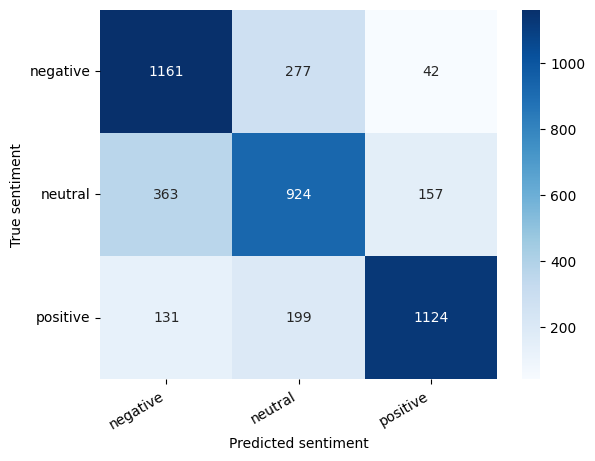

In [ ]:
print("svm confusion matrix")
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Naive Bayes

In [ ]:
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
pred=bnb.predict(x_test)
print("bnb accuracy: ",accuracy_score(y_test, pred))
print("bnb f1: ",f1_score(y_test, pred, average='weighted'))

with open('bnb.pkl', 'wb') as file:
    pickle.dump(bnb, file)

models.append('bnb.pkl')

bnb accuracy:  0.685701233439927
bnb f1:  0.6854192155102403


In [ ]:
print("bnb classification report")
print(classification_report(y_test, pred))

bnb classification report
              precision    recall  f1-score   support

           0       0.69      0.76      0.73      1480
           1       0.59      0.57      0.58      1444
           2       0.78      0.72      0.75      1454

    accuracy                           0.69      4378
   macro avg       0.69      0.68      0.68      4378
weighted avg       0.69      0.69      0.69      4378



bnb confusion matrix


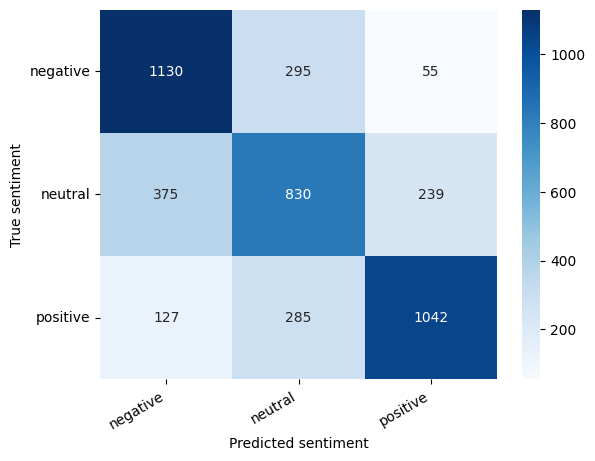

In [ ]:
print("bnb confusion matrix")
cm = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

# Test Machine Learning

In [ ]:
word2vec_model = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_model.bin')

In [ ]:
for model in models:
  print("##########")
  print(" testing with",model)
  with open(model, 'rb') as file:
    loaded_model = pickle.load(file)

  test_sentences = ["عجبني هايل", "نص نص", "سامط"]
  # Convert the test sentence to Word2Vec embeddings
  for sentence in test_sentences:
    # Convert the test sentence to Word2Vec embeddings
    test_embedding = np.mean([word2vec_model.wv[word] for word in sentence.split() if word in word2vec_model.wv]
                             or [np.zeros(word2vec_model.vector_size)], axis=0)

    # Make prediction using the loaded Logistic Regression model
    predicted_label = loaded_model.predict([test_embedding])

    print(f"Sentence: {sentence}")
    print(f"Predicted label: {predicted_label[0]}")
    print()

##########
 testing with svm.pkl
Sentence: عجبني هايل
Predicted label: 2

Sentence: نص نص
Predicted label: 1

Sentence: سامط
Predicted label: 0

##########
 testing with bnb.pkl
Sentence: عجبني هايل
Predicted label: 1

Sentence: نص نص
Predicted label: 1

Sentence: سامط
Predicted label: 2



# Deep Learning with three labels

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
len(tokenizer.word_index) + 1

47800

In [ ]:
max_sequence_length= 300

In [ ]:
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(df.sentiment.values)

In [ ]:
y = np.eye(len(label_mapping))[y]
y

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       ...,
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=21)

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
  if word in word2vec_model.wv:
    embedding_matrix[i] = word2vec_model.wv[word]
print(embedding_matrix.shape)

(47800, 300)


In [ ]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1, max_sequence_length, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

In [ ]:
def build_model(hp):
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
  dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)

  model = Sequential()
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(256, dropout=dropout_rate,
                               recurrent_dropout=dropout_rate,
                               return_sequences=True)))
  model.add(GlobalMaxPool1D())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(3, activation='softmax'))

  # Compile the model
  optimizer = Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='categorical_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Define the Hyperband tuner
tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=3,
                  factor=3,
                  directory='/content/drive/MyDrive/Colab Notebooks/PFE/wordembedding_hyper_3',
                  project_name='sentiment_analysis')

In [ ]:
tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Trial 6 Complete [00h 52m 18s]
val_accuracy: 0.7597076296806335

Best val_accuracy So Far: 0.7736409306526184
Total elapsed time: 00h 52m 18s


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
print(best_hps.values)

{'learning_rate': 0.01, 'dropout_rate': 0.1, 'tuner/epochs': 3, 'tuner/initial_epoch': 1, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0001'}


In [ ]:
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          14340000  
                                                                 
 bidirectional_1 (Bidirectio  (None, 300, 512)         1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 128)               65664     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = final_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, callbacks=[early_stopping])

Epoch 1/15
411/411 [==============================] - 1085s 3s/step - loss: 0.6948 - accuracy: 0.7087 - val_loss: 0.5762 - val_accuracy: 0.7471
Epoch 2/15
411/411 [==============================] - 1074s 3s/step - loss: 0.5801 - accuracy: 0.7715 - val_loss: 0.5906 - val_accuracy: 0.7558
Epoch 3/15
411/411 [==============================] - 1071s 3s/step - loss: 0.5523 - accuracy: 0.7813 - val_loss: 0.5602 - val_accuracy: 0.7691
Epoch 4/15
411/411 [==============================] - 1070s 3s/step - loss: 0.5424 - accuracy: 0.7854 - val_loss: 0.5511 - val_accuracy: 0.7764
Epoch 5/15
411/411 [==============================] - 1072s 3s/step - loss: 0.5602 - accuracy: 0.7790 - val_loss: 0.5613 - val_accuracy: 0.7688
Epoch 6/15
411/411 [==============================] - 1068s 3s/step - loss: 0.5298 - accuracy: 0.7915 - val_loss: 0.5670 - val_accuracy: 0.7634
Epoch 7/15
411/411 [==============================] - 1057s 3s/step - loss: 0.5117 - accuracy: 0.7979 - val_loss: 0.5789 - val_accuracy:

In [ ]:
final_model.save('/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_bilstm_3.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_bilstm_3.h5')

In [ ]:
# Evaluate the final model
loss, accuracy = model.evaluate(x_test, y_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)

137/137 [==============================] - 170s 1s/step - loss: 0.5710 - accuracy: 0.7698
Test Loss: 0.5709967613220215
Test Accuracy: 0.769757866859436


In [ ]:
pred = model.predict(x_test)

137/137 [==============================] - 175s 1s/step


In [ ]:
pred = np.argmax(pred, axis=1)
y_test_original=np.argmax(y_test, axis=1)

In [ ]:
print("deep learning classification report")
print(classification_report(y_test_original, pred))

deep learning classification report
              precision    recall  f1-score   support

           0       0.76      0.84      0.80      1480
           1       0.73      0.64      0.68      1444
           2       0.82      0.82      0.82      1454

    accuracy                           0.77      4378
   macro avg       0.77      0.77      0.77      4378
weighted avg       0.77      0.77      0.77      4378



deep learning confusion matrix


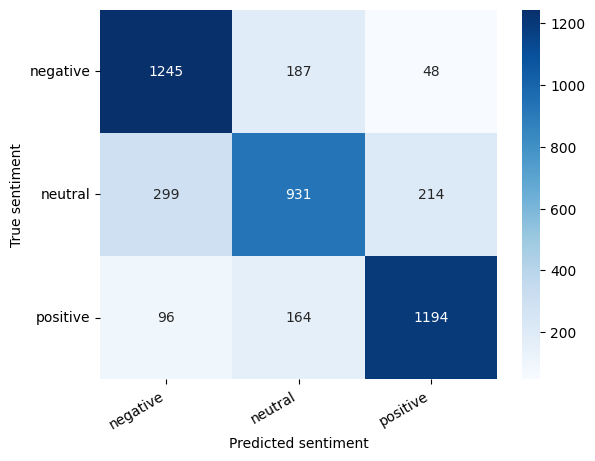

In [ ]:
print("deep learning confusion matrix")
cm = confusion_matrix(y_test_original, pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

## Test

In [ ]:
new_texts = ["حرام غالي بزاف خلي يصدي ", "شحال دير ؟", "بارك الله فيك"]
new_sequences = tokenizer.texts_to_sequences(new_texts)
new_X = pad_sequences(new_sequences, maxlen=max_sequence_length)
predictions = model.predict(new_X)
predicted_labels = np.argmax(predictions, axis=1)
predicted_sentiments = []
for label in predicted_labels:
    sentiment = [key for key, value in label_mapping.items() if value == label][0]
    predicted_sentiments.append(sentiment)
print("Predictions:", predictions)
print("predicted_labels:", predicted_labels)
print('predicted_sentiments:',predicted_sentiments)

1/1 [==============================] - 0s 478ms/step
Predictions: [[6.0437202e-01 2.9729441e-01 9.8333627e-02]
 [2.0296965e-03 9.7024888e-01 2.7721507e-02]
 [4.9944269e-06 1.6050696e-02 9.8394430e-01]]
predicted_labels: [0 1 2]
predicted_sentiments: ['negative', 'neutral', 'positive']


# Deep Learning with two labels

In [ ]:
word2vec_model = Word2Vec.load('/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_model.bin')

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['text'])
sequences = tokenizer.texts_to_sequences(df['text'])

In [ ]:
len(tokenizer.word_index) + 1

47800

In [ ]:
max_sequence_length= 300

In [ ]:
X = pad_sequences(sequences, maxlen=max_sequence_length)
y = np.array(df.sentiment.values)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=21)

In [ ]:
x_new = np.empty((0, x_train.shape[1]), x_train.dtype)
y_new = np.empty((0,), y_train.dtype)
for i in range(len(y_train)):
  if y_train[i] != 1:
    #x_train_binary.append(x_train[i])
    x_new = np.vstack((x_new, x_train[i]))
    y_new = np.append(y_new, y_train[i])
    #y_train_binary.append(y_train[i])

In [ ]:
for i in range(len(y_new)):
    if y_new[i] == 2:
        y_new[i] = 1

In [ ]:
x_train, x_val, y_train, y_val = train_test_split(x_new, y_new, test_size=0.25, random_state=21)

In [ ]:
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, 300))
for word, i in tokenizer.word_index.items():
  if word in word2vec_model.wv:
    embedding_matrix[i] = word2vec_model.wv[word]
print(embedding_matrix.shape)

(47800, 300)


In [ ]:
embedding_layer = Embedding(len(tokenizer.word_index) + 1, max_sequence_length, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False)

In [ ]:
def build_model(hp):
  learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
  dropout_rate = hp.Float('dropout_rate', 0.1, 0.5, step=0.1)

  model = Sequential()
  model.add(embedding_layer)
  model.add(Bidirectional(LSTM(256, dropout=dropout_rate,
                               recurrent_dropout=dropout_rate,
                               return_sequences=True)))
  model.add(GlobalMaxPool1D())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(32, activation='relu'))
  model.add(Dropout(dropout_rate))
  model.add(Dense(1, activation='sigmoid'))

  # Compile the model
  optimizer = Adam(learning_rate=learning_rate)

  model.compile(optimizer=optimizer,
                loss='binary_crossentropy',
                metrics=['accuracy'])

  return model

In [ ]:
# Define the Hyperband tuner
tuner = Hyperband(build_model,
                  objective='val_accuracy',
                  max_epochs=3,
                  factor=3,
                  directory='/content/drive/MyDrive/Colab Notebooks/PFE/wordembedding_hyper_3',
                  project_name='sentiment_analysis')

In [ ]:
#tuner.search(x_train, y_train, validation_data=(x_test, y_test), epochs=15)

Trial 6 Complete [00h 52m 18s]
val_accuracy: 0.7597076296806335

Best val_accuracy So Far: 0.7736409306526184
Total elapsed time: 00h 52m 18s


In [ ]:
best_hps = tuner.get_best_hyperparameters(1)[0]

In [ ]:
print(best_hps.values)

{'learning_rate': 0.01, 'dropout_rate': 0.1, 'tuner/epochs': 3, 'tuner/initial_epoch': 1, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0001'}


In [ ]:
final_model = tuner.hypermodel.build(best_hps)
final_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 300)          14340000  
                                                                 
 bidirectional_3 (Bidirectio  (None, 300, 512)         1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_3 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_12 (Dense)            (None, 128)               65664     
                                                                 
 dropout_9 (Dropout)         (None, 128)               0         
                                                                 
 dense_13 (Dense)            (None, 64)               

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)
history = final_model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=15, callbacks=[early_stopping])

Epoch 1/15
274/274 [==============================] - 738s 3s/step - loss: 0.2826 - accuracy: 0.8919 - val_loss: 0.2189 - val_accuracy: 0.9114
Epoch 2/15
274/274 [==============================] - 704s 3s/step - loss: 0.2044 - accuracy: 0.9309 - val_loss: 0.2461 - val_accuracy: 0.9042
Epoch 3/15
274/274 [==============================] - 702s 3s/step - loss: 0.1704 - accuracy: 0.9391 - val_loss: 0.2173 - val_accuracy: 0.9145
Epoch 4/15
274/274 [==============================] - 712s 3s/step - loss: 0.1424 - accuracy: 0.9498 - val_loss: 0.2645 - val_accuracy: 0.9173
Epoch 5/15
274/274 [==============================] - 697s 3s/step - loss: 0.1379 - accuracy: 0.9478 - val_loss: 0.2053 - val_accuracy: 0.9176
Epoch 6/15
274/274 [==============================] - 682s 2s/step - loss: 0.1306 - accuracy: 0.9508 - val_loss: 0.2185 - val_accuracy: 0.9204
Epoch 7/15
274/274 [==============================] - 657s 2s/step - loss: 0.1309 - accuracy: 0.9519 - val_loss: 0.3316 - val_accuracy: 0.9142

In [ ]:
final_model.save('/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_bilstm_2.h5')

In [ ]:
model = load_model('/content/drive/MyDrive/Colab Notebooks/PFE/word2vec_bilstm_2.h5')

In [ ]:
predictions = model.predict(x_test)

137/137 [==============================] - 26s 188ms/step


In [ ]:
predicted_labels = []
for prob in predictions:
    if prob < 0.33:
        predicted_labels.append(0)
    elif prob > 0.66:
        predicted_labels.append(2)
    else:
        predicted_labels.append(1)

In [ ]:
predicted_labels

In [ ]:
print("svm accuracy: ",accuracy_score(y_test, predicted_labels))
print("svm f1: ",f1_score(y_test, predicted_labels, average='weighted'))

svm accuracy:  0.661717679305619
svm f1:  0.6314388225336798


In [ ]:
print("mnb classification report")
print(classification_report(y_test, predicted_labels))

mnb classification report
              precision    recall  f1-score   support

           0       0.70      0.85      0.77      1480
           1       0.56      0.29      0.38      1444
           2       0.67      0.84      0.75      1454

    accuracy                           0.66      4378
   macro avg       0.64      0.66      0.63      4378
weighted avg       0.64      0.66      0.63      4378



mnb confusion matrix


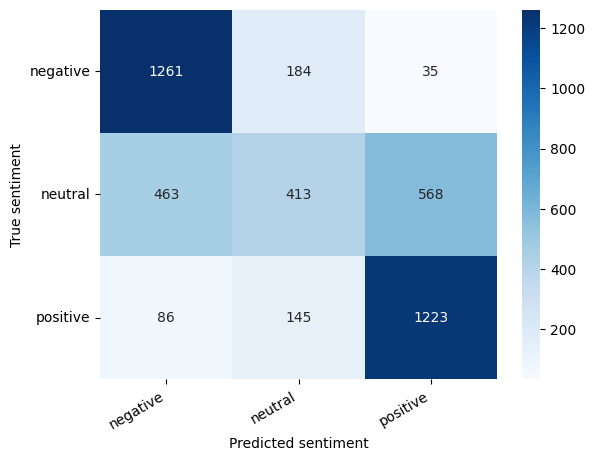

In [ ]:
print("mnb confusion matrix")
cm = confusion_matrix(y_test, predicted_labels)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)